In [9]:
# Author: M. Riley Owens (GitHub: mrileyowens)

# This file creates a figure showing the results
# of modeling a foreground galaxy covering the 
# Sunburst Arc

In [10]:
import os
import glob

import numpy as np

import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.nddata.utils import Cutout2D
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText

In [11]:
def plot():

    home = os.getcwd()

    data = f'{home}/data'
    figs = f'{home}/figs'

    # F275W observations and GALFIT residuals
    #f275w = 'data/hst/V4.0_PSZ1G311.65-18.48_F275W_0.03g0.8_cr2.5_0.7_drc_sci.fits'
    #f275w_residual = 'data/hst/sunburst_275_result__residual_updated.fits'

    f275w_files = glob.glob(f'{data}/hst/galfit_cutouts/f275w_result_*_v5_wcs.fits')
    f814w_files = glob.glob(f'{data}/hst/galfit_cutouts/f814w_result_*_v5_wcs.fits')

    wcs = WCS(fits.getheader(f275w_files[0]))

    center = SkyCoord(frame='fk5', ra='15h50m04.37s', dec='-78d10m59.75s')
    size = 3.2 * u.arcsecond

    f275w_source_mask = (fits.getdata(f275w_files[0]) >= np.abs(np.median(fits.getdata(f275w_files[0]))))
    f814w_source_mask = (fits.getdata(f814w_files[0]) >= 8 * np.abs(np.median(fits.getdata(f814w_files[0]))))

    masks = np.array([f275w_source_mask, f814w_source_mask])

    fig, ax = plt.subplots(3,2, figsize=(5,7.5), constrained_layout=True)
    plt.subplots_adjust(hspace=0, wspace=0)

    #fig.supxlabel(r'$\Delta$ Right ascension (")', x=(fig.subplotpars.right + fig.subplotpars.left)/2)
    #fig.supylabel(r'$\Delta$ Declination (")')

    ax[0,0].tick_params(labelbottom=False, labelleft=True, top=True, right=True, direction='in')
    ax[1,0].tick_params(labelbottom=False, labelleft=True, top=True, right=True, direction='in')
    ax[2,0].tick_params(labelbottom=True, labelleft=True, top=True, right=True, direction='in')
    
    ax[0,1].tick_params(labelbottom=False, labelleft=False, top=True, right=True, direction='in')
    ax[1,1].tick_params(labelbottom=False, labelleft=False, top=True, right=True, direction='in')
    ax[2,1].tick_params(labelbottom=True, labelleft=False, top=True, right=True, direction='in')


    '''
    for i, subplot in enumerate(ax.flatten()):

        shape = np.shape(fits.getdata(f275w_files[0]))

        subplot.set_xlim(shape[0] / 2 - 1.5 / 0.03, shape[0] / 2 + 1.5 / 0.03)
        subplot.set_ylim(shape[1] / 2 - 1.5 / 0.03, shape[1] / 2 + 1.5 / 0.03)

        subplot.set_xticks([shape[0] / 2 - 1 / 0.03,
                            shape[0] / 2,
                            shape[0] / 2 + 1 / 0.03],
                           ['$+$1', '0', '$-$1'])
        subplot.set_yticks([shape[1] / 2 - 1 / 0.03,
                            shape[1] / 2,
                            shape[1] / 2 + 1 / 0.03],
                           ['$-$1', '0', '$+$1'])
        #subplot.set_aspect('auto', adjustable='datalim')
    '''

    for i, files in enumerate([f275w_files, f814w_files]):

        for j, file in enumerate(files):

            cutout = Cutout2D(fits.getdata(file), center, size, wcs=WCS(fits.getheader(file)))

            #norm = Normalize(vmin=np.median(fits.getdata(files[0])) - np.std(fits.getdata(files[0])),
            #vmax=np.median(fits.getdata(files[0])) + np.std(fits.getdata(files[0])))

            min = abs(np.min(fits.getdata(files[0])))

            #norm = Normalize(vmin=np.median(fits.getdata(files[0])[~masks[i]]) - 3 * np.std(fits.getdata(files[0])[~masks[i]]),
            #    vmax=np.median(fits.getdata(files[0])[~masks[i]]) + 3 * np.std(fits.getdata(files[0])[~masks[i]]))
            vmin = np.median(fits.getdata(files[0])[~masks[i]]) - 2 * np.std(fits.getdata(files[0])[~masks[i]])
            vmax = np.median(fits.getdata(files[0])[~masks[i]]) + 100 * np.std(fits.getdata(files[0])[~masks[i]])
            #norm = Normalize(vmin=np.median(cutout[~masks[i]]) - 5 * np.std(cutout[~masks[i]]),
            #    vmax=np.median(cutout[~masks[i]]) + 5 * np.std(cutout[~masks[i]]))

            ax[j,i].imshow(cutout.data, origin='lower', cmap='viridis', norm=colors.PowerNorm(gamma=1/3, vmin=vmin, vmax=vmax))#vmin=vmin, vmax=vmax)
                #vmin=np.median(fits.getdata(files[0])) - np.std(fits.getdata(files[0])),
                #vmax=np.median(fits.getdata(files[0])) + np.std(fits.getdata(files[0])))

    for i, subplot in enumerate(ax.flatten()):

        shape = np.shape(cutout.data)

        subplot.set_xlim(shape[0] / 2 - 1.5 / 0.03, shape[0] / 2 + 1.5 / 0.03)
        subplot.set_ylim(shape[1] / 2 - 1.5 / 0.03, shape[1] / 2 + 1.5 / 0.03)

        subplot.set_xticks([shape[0] / 2 - 1 / 0.03,
                            shape[0] / 2,
                            shape[0] / 2 + 1 / 0.03],
                           ['$+$1', '0', '$-$1'])
        subplot.set_yticks([shape[1] / 2 - 1 / 0.03,
                            shape[1] / 2,
                            shape[1] / 2 + 1 / 0.03],
                           ['$-$1', '0', '$+$1'])
        subplot.set_aspect('auto', adjustable='datalim')

    fig.supxlabel(r'$\Delta$ Right ascension (")', ha='center')
    ax[1,0].set_ylabel(r'$\Delta$ Declination (")', fontsize='large')

    #print('original WCS: ' + '\n', WCS(fits.getheader(f275w)))

    # F814W observations and GALFIT residuals
    #f814w = 'data/hst/V4.0_PSZ1G311.65-18.48_F814W_0.03g0.8_cr2.5_0.7_drc_sci.fits'
    #f814w_residual = 'data/hst/sunburst_814_result__residual_updated.fits'

    '''
    center = SkyCoord(frame='fk5', ra='15h50m04.37s', dec='-78d10m59.75s')
    size = 3.2 * u.arcsecond

    f275w_cutout = Cutout2D(fits.getdata(f275w), center, size, wcs=WCS(fits.getheader(f275w)))
    f275w_residual_cutout = Cutout2D(fits.getdata(f275w_residual), center, size, wcs=WCS(fits.getheader(f275w_residual)))

    f814w_cutout = Cutout2D(fits.getdata(f814w), center, size, wcs=WCS(fits.getheader(f814w)))
    f814w_residual_cutout = Cutout2D(fits.getdata(f814w_residual), center, size, wcs=WCS(fits.getheader(f814w_residual)))

    hdul_wcs = f275w_cutout.wcs.to_fits()
    hdul_wcs[0].header['CRVAL1'] = hdul_wcs[0].header['CRVAL1'] - center.ra.degree 
    hdul_wcs[0].header['CRVAL2'] = hdul_wcs[0].header['CRVAL2'] - center.dec.degree 
    hdul_wcs[0].header['PC1_1'] = -4.74942508e-5

    wcs = WCS(hdul_wcs[0].header)

    fig, ax = plt.subplots(3,2, figsize=(5,7.5), constrained_layout=True)
    plt.subplots_adjust(hspace=0, wspace=0)

    fig.supxlabel(r'$\Delta$ Right ascension (")', y=0.06)
    fig.supylabel(r'$\Delta$ Declination (")')

    ax[0,0].tick_params(labelbottom=False, labelleft=True, top=True, right=True, direction='in')
    ax[1,0].tick_params(labelbottom=False, labelleft=True, top=True, right=True, direction='in')
    ax[2,0].tick_params(labelbottom=True, labelleft=True, top=True, right=True, direction='in')
    
    ax[0,1].tick_params(labelbottom=False, labelleft=False, top=True, right=True, direction='in')
    ax[1,1].tick_params(labelbottom=False, labelleft=False, top=True, right=True, direction='in')
    ax[2,1].tick_params(labelbottom=True, labelleft=False, top=True, right=True, direction='in')

    for i, subplot in enumerate(ax.flatten()):

        subplot.set_xlim(np.shape(cutout.data)[0] / 2 - 1.5 / 0.03, np.shape(cutout.data)[0] / 2 + 1.5 / 0.03)
        subplot.set_ylim(np.shape(cutout.data)[1] / 2 - 1.5 / 0.03, np.shape(cutout.data)[1] / 2 + 1.5 / 0.03)

        subplot.set_xticks([np.shape(cutout.data)[0] / 2 - 1 / 0.03,
                            np.shape(cutout.data)[0] / 2,
                            np.shape(cutout.data)[0] / 2 + 1 / 0.03],
                           ['$+$1', '0', '$-$1'])
        subplot.set_yticks([np.shape(cutout.data)[1] / 2 - 1 / 0.03,
                            np.shape(cutout.data)[1] / 2,
                            np.shape(cutout.data)[1] / 2 + 1 / 0.03],
                           ['$-$1', '0', '$+$1'])
        subplot.set_aspect('auto', adjustable='datalim')

    ax[0,0].imshow(f275w_cutout.data, cmap='viridis', origin='lower', 
        vmin=np.median(f275w_cutout.data), vmax=np.amax(f275w_cutout.data)/2)
    ax[1,0].imshow(f275w_cutout.data - f275w_residual_cutout.data / fits.getheader(f275w)['EXPTIME'], cmap='viridis', origin='lower', 
        vmin=np.median(f275w_cutout.data), vmax=np.amax(f275w_cutout.data)/2)
    ax[2,0].imshow(f275w_residual_cutout.data / fits.getheader(f275w)['EXPTIME'], cmap='viridis', origin='lower', 
        vmin=np.median(f275w_cutout.data), vmax=np.amax(f275w_cutout.data)/2)

    ax[0,1].imshow(f814w_cutout.data, cmap='viridis', origin='lower', 
        vmin=np.median(f814w_cutout.data), vmax=np.amax(f814w_cutout.data)/2)
    ax[1,1].imshow(f814w_cutout.data - f814w_residual_cutout.data / fits.getheader(f814w)['EXPTIME'], cmap='viridis', origin='lower', 
        vmin=np.median(f814w_cutout.data), vmax=np.amax(f814w_cutout.data)/2)
    ax[2,1].imshow(f814w_residual_cutout.data / fits.getheader(f814w)['EXPTIME'], cmap='viridis', origin='lower', 
        vmin=np.median(f814w_cutout.data), vmax=np.amax(f814w_cutout.data)/2)

    for i, subplot in enumerate([ax[0,0], ax[1,0], ax[2,0]]):
        at=AnchoredText('F275W', loc='upper left', frameon=False, prop=dict(color='white', fontweight='bold'))
        subplot.add_artist(at)
    for i, subplot in enumerate([ax[0,1], ax[1,1], ax[2,1]]):
        at=AnchoredText('F814W', loc='upper left', frameon=False, prop=dict(color='white', fontweight='bold'))
        subplot.add_artist(at)

    for i, subplot in enumerate([ax[0,0], ax[0,1]]):
        at=AnchoredText('Original', loc='upper right', frameon=False, prop=dict(color='white', fontweight='bold'))
        subplot.add_artist(at)
    for i, subplot in enumerate([ax[1,0], ax[1,1]]):
        at=AnchoredText('Model', loc='upper right', frameon=False, prop=dict(color='white', fontweight='bold'))
        subplot.add_artist(at)
    for i, subplot in enumerate([ax[2,0], ax[2,1]]):
        at=AnchoredText('Residual', loc='upper right', frameon=False, prop=dict(color='white', fontweight='bold'))
        subplot.add_artist(at)
    '''

    row_labels = np.array(['Original', 'Model', 'Residual'], dtype=str)

    for i in range(0,3):

        label1 = AnchoredText(row_labels[i], loc='upper right', frameon=False, prop=dict(color='white', fontweight='bold'))
        label2 = AnchoredText(row_labels[i], loc='upper right', frameon=False, prop=dict(color='white', fontweight='bold'))

        ax[i,0].add_artist(label1)
        ax[i,1].add_artist(label2)

    column_labels = np.array(['F275W', 'F814W'], dtype=str)

    for i in range(0,2):

        label1 = AnchoredText(column_labels[i], loc='upper left', frameon=False, prop=dict(color='white', fontweight='bold'))
        label2 = AnchoredText(column_labels[i], loc='upper left', frameon=False, prop=dict(color='white', fontweight='bold'))
        label3 = AnchoredText(column_labels[i], loc='upper left', frameon=False, prop=dict(color='white', fontweight='bold'))

        ax[0,i].add_artist(label1)
        ax[1,i].add_artist(label2)
        ax[2,i].add_artist(label3)

    fig.savefig(f'{figs}/galfit_result.pdf', bbox_inches='tight')

C:\Users\15136\AppData\Local\Temp/ipykernel_21320/3722359682.py:26: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0, wspace=0)


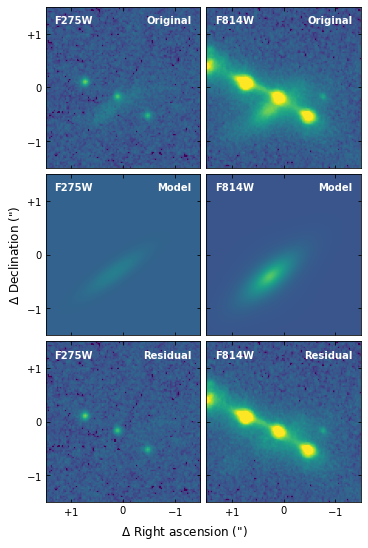

In [12]:
plot()